<a id="toc"></a>
# Оглавление

[Введение](#intro)  
[Описание исходных данных и признаков](#data-desc)  
[Виртуальное окружение и импорты](#env)  
[1. Предварительная обработка данных](#sec-1)  
   [1.1. Чтение и загрузка данных](#sec-1-1)  
   [1.2. Первичный анализ данных](#sec-1-2)
   [1.3. Разделение на train/test](#sec-1-3)  
   [1.4. Обработка пропусков и кодирование категорий](#sec-1-4)  
   [1.5. Детекция выбросов и аномалий](#sec-1-5)  
   [1.6. Итоги раздела 1](#sec-1-6)  
[2. Генерация новых признаков](#sec-2)  
[3. Выбор моделей ML и метрик](#sec-3)  
[4. Обучение моделей ML и подбор гиперпараметров](#sec-4)  
[5. Вычисление метрик на новых данных](#sec-5)  
[6. Результат работы](#sec-6)  

<a id="intro"></a>
# Введение

[к оглавлению](#toc)

Задача — предсказать целевой показатель **«Гармония Бессмертия»** по измерениям параметров портала.

Это задача регрессии, так как целевая переменная числовая.

<a id="data-desc"></a>
## Описание исходных данных и признаков

[к оглавлению](#toc)

Данные — журнал измерений параметров портала. Каждая строка соответствует одному наблюдению, столбцы — признаки. Целевая переменная — `Гармония Бессмертия`.

### Таблица признаков

| Признак | Роль | Тип | Краткое описание |
| --- | --- | --- | --- |
| Вектор Мощи | входной | числовой | Позиция механизма, управляющего интенсивностью перехода. |
| Скорость перехода через портал | входной | числовой | Скорость перемещения объектов через портал. |
| Приток Силы Потока | входной | числовой | Поток силы через ядро портала. |
| Ритм магического ядра | входной | числовой | Обороты ядра в минуту. |
| Поток Энергий | входной | числовой | Обороты генератора эфира. |
| Сила Левого Потока | входной | числовой | Мощность левого потока. |
| Сила Правого Потока | входной | числовой | Мощность правого потока. |
| Пламя Стихий | входной | числовой | Температура энергии (°C). |
| Температура вдоха Истока | входной | числовой | Температура на входе (°C). |
| Температура выдоха Истока | входной | числовой | Температура на выходе (°C). |
| Приток давления Выдоха Истока | входной | числовой | Давление потока на выходе. |
| Давление вдоха Истока | входной (кандидат на удаление) | числовой | Давление на входе; близко к константе. |
| Давление выдоха Истока | входной | числовой | Давление на выходе. |
| Древний Ветер | входной (кандидат на удаление) | числовой | Признак с большим числом пропусков. |
| Печать Чародея | входной | числовой | Параметр управления, %. |
| Эмульсия Истока | входной | числовой | Количество топлива. |
| Дыхание Истока | входной | числовой | Коэффициент угасания ускорителя. |
| Гармония Бессмертия | целевой | числовой | Целевой показатель состояния ядра. |
| Тип Вектора Мощи | входной | категориальный | Категория: Слабый / Ниже среднего / Выше среднего / Сильный. |
| Номер пометки | служебный (удаляется) | целочисленный | Идентификатор записи. |

### Формулы предметной области

Допустимые (для генерации новых признаков):
- **Суммарная мощность потоков**: `Сила Левого Потока + Сила Правого Потока (+ Приток Силы Потока)`
- **Сила ядра**: `Ритм магического ядра * Приток Силы Потока`
- **Общее выходное давление**: `Приток давления Выдоха Истока + Давление выдоха Истока`
- **Магическая производительность**: `Скорость перехода через портал / Эмульсия Истока`
- **Эффективность ядра**: `Поток Энергий / Эмульсия Истока`
- **Мощность с температурным градиентом**: `(Пламя Стихий - Температура вдоха Истока) * (Приток давления Выдоха Истока + Давление выдоха Истока)`

<a id="env"></a>
## Виртуальное окружение и основные импорты

[к оглавлению](#toc)


In [1]:
import random
import warnings
from pathlib import Path
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from sklearn.cluster import DBSCAN

import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

plt.style.use("ggplot")

SEED = 13
np.random.seed(SEED)
random.seed(SEED)

warnings.filterwarnings("ignore")


<a id="sec-1"></a>
# 1. Предварительная обработка данных

[к оглавлению](#toc)

<a id="sec-1-1"></a>
## 1.1. Чтение и загрузка данных

[к оглавлению](#toc)

In [2]:
path = r"portal_data.csv"
na_vals = ["-", "Не определено", "", "NA", "NaN"]

df = pd.read_csv(path, sep="|", encoding="utf-8", na_values=na_vals)
df.columns = [c.strip() for c in df.columns]

print("shape =", df.shape)
df.head(3)

shape = (11934, 20)


,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Тип Вектора Мощи,Номер пометки
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,NaN,1.096,NaN,5.947,NaN,7.137,0.082,0.95,0.975,Слабый,0
1,2.088,NaN,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975,Слабый,1
2,3.144,4.62996,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,NaN,1.389,NaN,7.574,NaN,13.086,0.259,0.95,0.975,Ниже среднего,2


<a id="sec-1-2"></a>
## 1.2. Первичный анализ данных

[к оглавлению](#toc)

Приведение типов признаков (числовые/категориальные) и базовая сводка по таблице (пропуски, служебные поля).

In [3]:
cat_cols = ["Тип Вектора Мощи"]

for col in df.columns:
    if col in cat_cols:
        df[col] = df[col].astype("category")
    elif col != "Номер пометки":
        df[col] = pd.to_numeric(df[col], errors="coerce")

df["Номер пометки"] = pd.to_numeric(df["Номер пометки"], errors="coerce").astype("Int64")

df.dtypes

Вектор Мощи                        float64
Скорость перехода через портал     float64
Приток Силы Потока                 float64
Ритм магического ядра              float64
Поток Энергий                      float64
Сила Левого Потока                 float64
Сила Правого Потока                float64
Пламя Стихий                       float64
Температура вдоха Истока             int64
Температура выдоха Истока          float64
Приток давления Выдоха Истока      float64
Давление вдоха Истока              float64
Давление выдоха Истока             float64
Древний Ветер                      float64
Печать Чародея                     float64
Эмульсия Истока                    float64
Дыхание Истока                     float64
Гармония Бессмертия                float64
Тип Вектора Мощи                  category
Номер пометки                        Int64
dtype: object

<a id="sec-1-3"></a>
## 1.3. Разделение выборки на обучающую и тестовую выборки

[к оглавлению](#toc)

Удаление служебных/неинформативных признаков и разбиение на обучающую и тестовую выборки.

In [4]:
to_drop = []
if "Номер пометки" in df.columns:
    to_drop.append("Номер пометки")

to_drop += [c for c in df.columns if df[c].isna().mean() > 0.5]
to_drop += [c for c in df.columns if df[c].nunique(dropna=True) == len(df)]
to_drop += [c for c in df.columns if df[c].nunique(dropna=True) <= 1]

to_drop = sorted(list(dict.fromkeys(to_drop)))
print("Отбрасываем:", to_drop)

df = df.drop(columns=to_drop)
print("shape после отброса:", df.shape)

TARGET_COL = "Гармония Бессмертия"
X = df.drop(columns=[TARGET_COL]).copy()
y = df[TARGET_COL].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

print(f"Размеры: X_train={X_train.shape}, X_test={X_test.shape}")

Отбрасываем: ['Давление вдоха Истока', 'Древний Ветер', 'Номер пометки', 'Температура вдоха Истока', 'Температура выдоха Истока']
shape после отброса: (11934, 15)
Размеры: X_train=(9547, 14), X_test=(2387, 14)


<a id="sec-1-4"></a>
## 1.4. Обработка вещественных признаков (заполнение пропусков)

[к оглавлению](#toc)

Заполнение пропусков в числовых признаках.

Этапы:

- кодирование категориального признака `Тип Вектора Мощи` в числовой вид;
- статистическое заполнение (выбор mean/median/mode по минимальной KL-дивергенции);
- заполнение с помощью `KNNImputer`.

### Кодировка категориального признака

Категориальный признак `Тип Вектора Мощи` преобразуется в порядковый числовой формат (с фиксированным порядком категорий).

In [5]:
cat_col = "Тип Вектора Мощи"

X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

order = ["Слабый", "Ниже среднего", "Выше среднего", "Сильный"]
mapping = {cat: i for i, cat in enumerate(order)}
print("Кодировка Тип Вектора Мощи:", mapping)

X_train_enc[cat_col] = X_train_enc[cat_col].map(mapping).astype(float)
X_test_enc[cat_col] = X_test_enc[cat_col].map(mapping).astype(float)

X_train_enc[[cat_col]].head()

Кодировка Тип Вектора Мощи: {'Слабый': 0, 'Ниже среднего': 1, 'Выше среднего': 2, 'Сильный': 3}


,Тип Вектора Мощи
4234,2.0
11566,0.0
1420,3.0
9628,3.0
3538,0.0


### Статистическое заполнение пропусков (KL-дивергенция)

Для признаков с пропусками выбирается значение заполнения (mean/median/mode) по критерию минимальной KL-дивергенции между распределениями до/после заполнения.

Признаки с пропусками: ['Скорость перехода через портал']
Колонка: Скорость перехода через портал
mean: value=7.7056, KL=0.107609
median: value=7.7166, KL=0.029040
mode: value=1.5433, KL=0.028882
Лучший вариант: mode => 1.5433


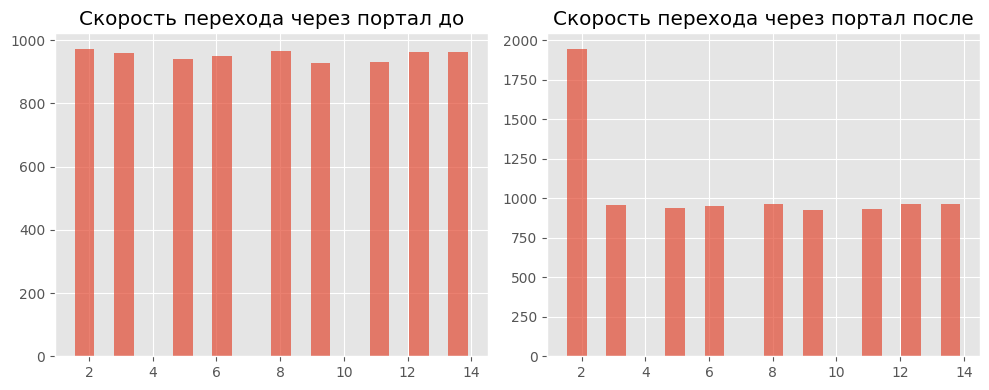

In [6]:
na_cols = [c for c in X_train_enc.columns if X_train_enc[c].isna().any()]
print("Признаки с пропусками:", na_cols)


def kl_divergence(p, q):
    eps = 1e-8
    p = p + eps
    q = q + eps
    p = p / p.sum()
    q = q / q.sum()
    return np.sum(p * np.log(p / q))


def kl_for_value(series, value, bins=20):
    base = series.dropna()
    hist_base, edges = np.histogram(base, bins=bins, density=True)
    filled = series.fillna(value)
    hist_filled, _ = np.histogram(filled, bins=edges, density=True)
    return kl_divergence(hist_base, hist_filled)


best_fill = {}

for col in na_cols:
    s = X_train_enc[col]
    candidates = {
        "mean": s.mean(),
        "median": s.median(),
        "mode": s.mode().iloc[0],
    }
    scores = {}
    print("Колонка:", col)
    for name, val in candidates.items():
        kl = kl_for_value(s, val, bins=20)
        scores[name] = kl
        print(f"{name}: value={val:.4f}, KL={kl:.6f}")
    best_name = min(scores, key=scores.get)
    best_fill[col] = candidates[best_name]
    print("Лучший вариант:", best_name, "=>", round(best_fill[col], 4))

if na_cols:
    col = na_cols[0]
    s = X_train_enc[col]
    val = best_fill[col]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(s.dropna(), bins=20, alpha=0.7)
    plt.title(col + " до")
    plt.subplot(1, 2, 2)
    plt.hist(s.fillna(val), bins=20, alpha=0.7)
    plt.title(col + " после")
    plt.tight_layout()

Заполнил пропуски в «Скорость перехода через портал» значением, выбранным по минимальной KL‑дивергенции (сравнивались варианты mean/median/mode). Признак дискретный, поэтому распределение выглядит как набор отдельных столбиков. После заполнения увеличилась частота выбранного значения — это ожидаемый эффект при заполнении константой. При этом выбранное значение минимально искажает исходное распределение по критерию KL, поэтому такое заполнение можно считать адекватным для дальнейшего обучения моделей.

In [7]:
X_train_stat = X_train_enc.copy()
X_test_stat = X_test_enc.copy()

for col, val in best_fill.items():
    X_train_stat[col] = X_train_stat[col].fillna(val)
    X_test_stat[col] = X_test_stat[col].fillna(val)

X_train_stat.isna().sum()

Вектор Мощи                       0
Скорость перехода через портал    0
Приток Силы Потока                0
Ритм магического ядра             0
Поток Энергий                     0
Сила Левого Потока                0
Сила Правого Потока               0
Пламя Стихий                      0
Приток давления Выдоха Истока     0
Давление выдоха Истока            0
Печать Чародея                    0
Эмульсия Истока                   0
Дыхание Истока                    0
Тип Вектора Мощи                  0
dtype: int64

### Машинное заполнение пропусков (KNNImputer)

Заполнение пропусков методом `KNNImputer` на основе ближайших соседей (обучение на train, применение к test).

In [8]:
imputer_knn = KNNImputer(n_neighbors=5)

X_train_knn_arr = imputer_knn.fit_transform(X_train_enc)
X_test_knn_arr = imputer_knn.transform(X_test_enc)

X_train_knn = pd.DataFrame(X_train_knn_arr, columns=X_train_enc.columns, index=X_train_enc.index)
X_test_knn = pd.DataFrame(X_test_knn_arr, columns=X_test_enc.columns, index=X_test_enc.index)

X_train_knn.isna().sum()

Вектор Мощи                       0
Скорость перехода через портал    0
Приток Силы Потока                0
Ритм магического ядра             0
Поток Энергий                     0
Сила Левого Потока                0
Сила Правого Потока               0
Пламя Стихий                      0
Приток давления Выдоха Истока     0
Давление выдоха Истока            0
Печать Чародея                    0
Эмульсия Истока                   0
Дыхание Истока                    0
Тип Вектора Мощи                  0
dtype: int64

#### Сравнение распределений до/после KNNImputer

Сравнение распределения признака с пропусками до и после заполнения `KNNImputer` на обучающей выборке.

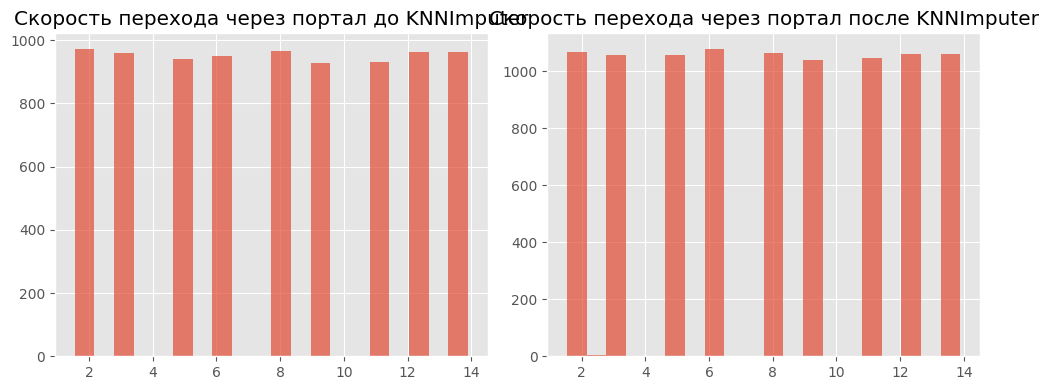

In [9]:
cols_to_check = [c for c in X_train_enc.columns if X_train_enc[c].isna().any()]

if cols_to_check:
    col = cols_to_check[0]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(X_train_enc[col].dropna(), bins=20, alpha=0.7)
    plt.title(col + " до KNNImputer")
    plt.subplot(1, 2, 2)
    plt.hist(X_train_knn[col], bins=20, alpha=0.7)
    plt.title(col + " после KNNImputer")
    plt.tight_layout()

Слева распределение признака до заполнения, справа — после KNNImputer. По виду гистограмм распределение осталось примерно тем же: KNN не вставляет одну константу, а раскидывает значения более естественно. В целом выглядит как более “мягкое” заполнение, ближе к реальным данным.

### Оценка качества заполнения (NRMSE)

Оценка качества `KNNImputer` по NRMSE на искусственно замаскированных пропусках.

In [10]:
cols_to_check = [c for c in X_train_enc.columns if X_train_enc[c].isna().any()]

if cols_to_check:
    mask_clean = X_train_enc[cols_to_check].notna().all(axis=1)
    X_clean = X_train_enc.loc[mask_clean].copy()
    print("Размер чистого датасета:", X_clean.shape)

    rng = np.random.default_rng(SEED)
    frac = 0.2
    X_masked = X_clean.copy()
    mask_idx = {}

    for col in cols_to_check:
        n = len(X_clean)
        k = int(n * frac)
        idx = rng.choice(X_clean.index, size=k, replace=False)
        mask_idx[col] = idx
        X_masked.loc[idx, col] = np.nan

    imputer_test = KNNImputer(n_neighbors=5)
    X_imputed = pd.DataFrame(
        imputer_test.fit_transform(X_masked),
        columns=X_masked.columns,
        index=X_masked.index,
    )

    def nrmse(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
        denom = y_true.max() - y_true.min()
        return float(rmse / denom) if denom != 0 else 0.0

    for col in cols_to_check:
        idx = mask_idx[col]
        y_true = X_clean.loc[idx, col]
        y_pred = X_imputed.loc[idx, col]
        score = nrmse(y_true, y_pred)
        print(f"{col}: NRMSE = {score:.4f}")
else:
    print("В обучающей выборке нет пропусков — NRMSE не вычисляю.")

Размер чистого датасета: (8573, 14)
Скорость перехода через портал: NRMSE = 0.0084


NRMSE очень низкий - качество заполнения практически идеальное

<a id="sec-1-5"></a>
## 1.5. Детекция выбросов и аномалий в данных

[к оглавлению](#toc)

Очистка обучающей выборки:

- выбросы: IQR и Robust Z-score (используется пересечение);
- аномалии: Isolation Forest, One-class SVM, DBSCAN (удаляем строки, которые попали в пересечение аномалий).

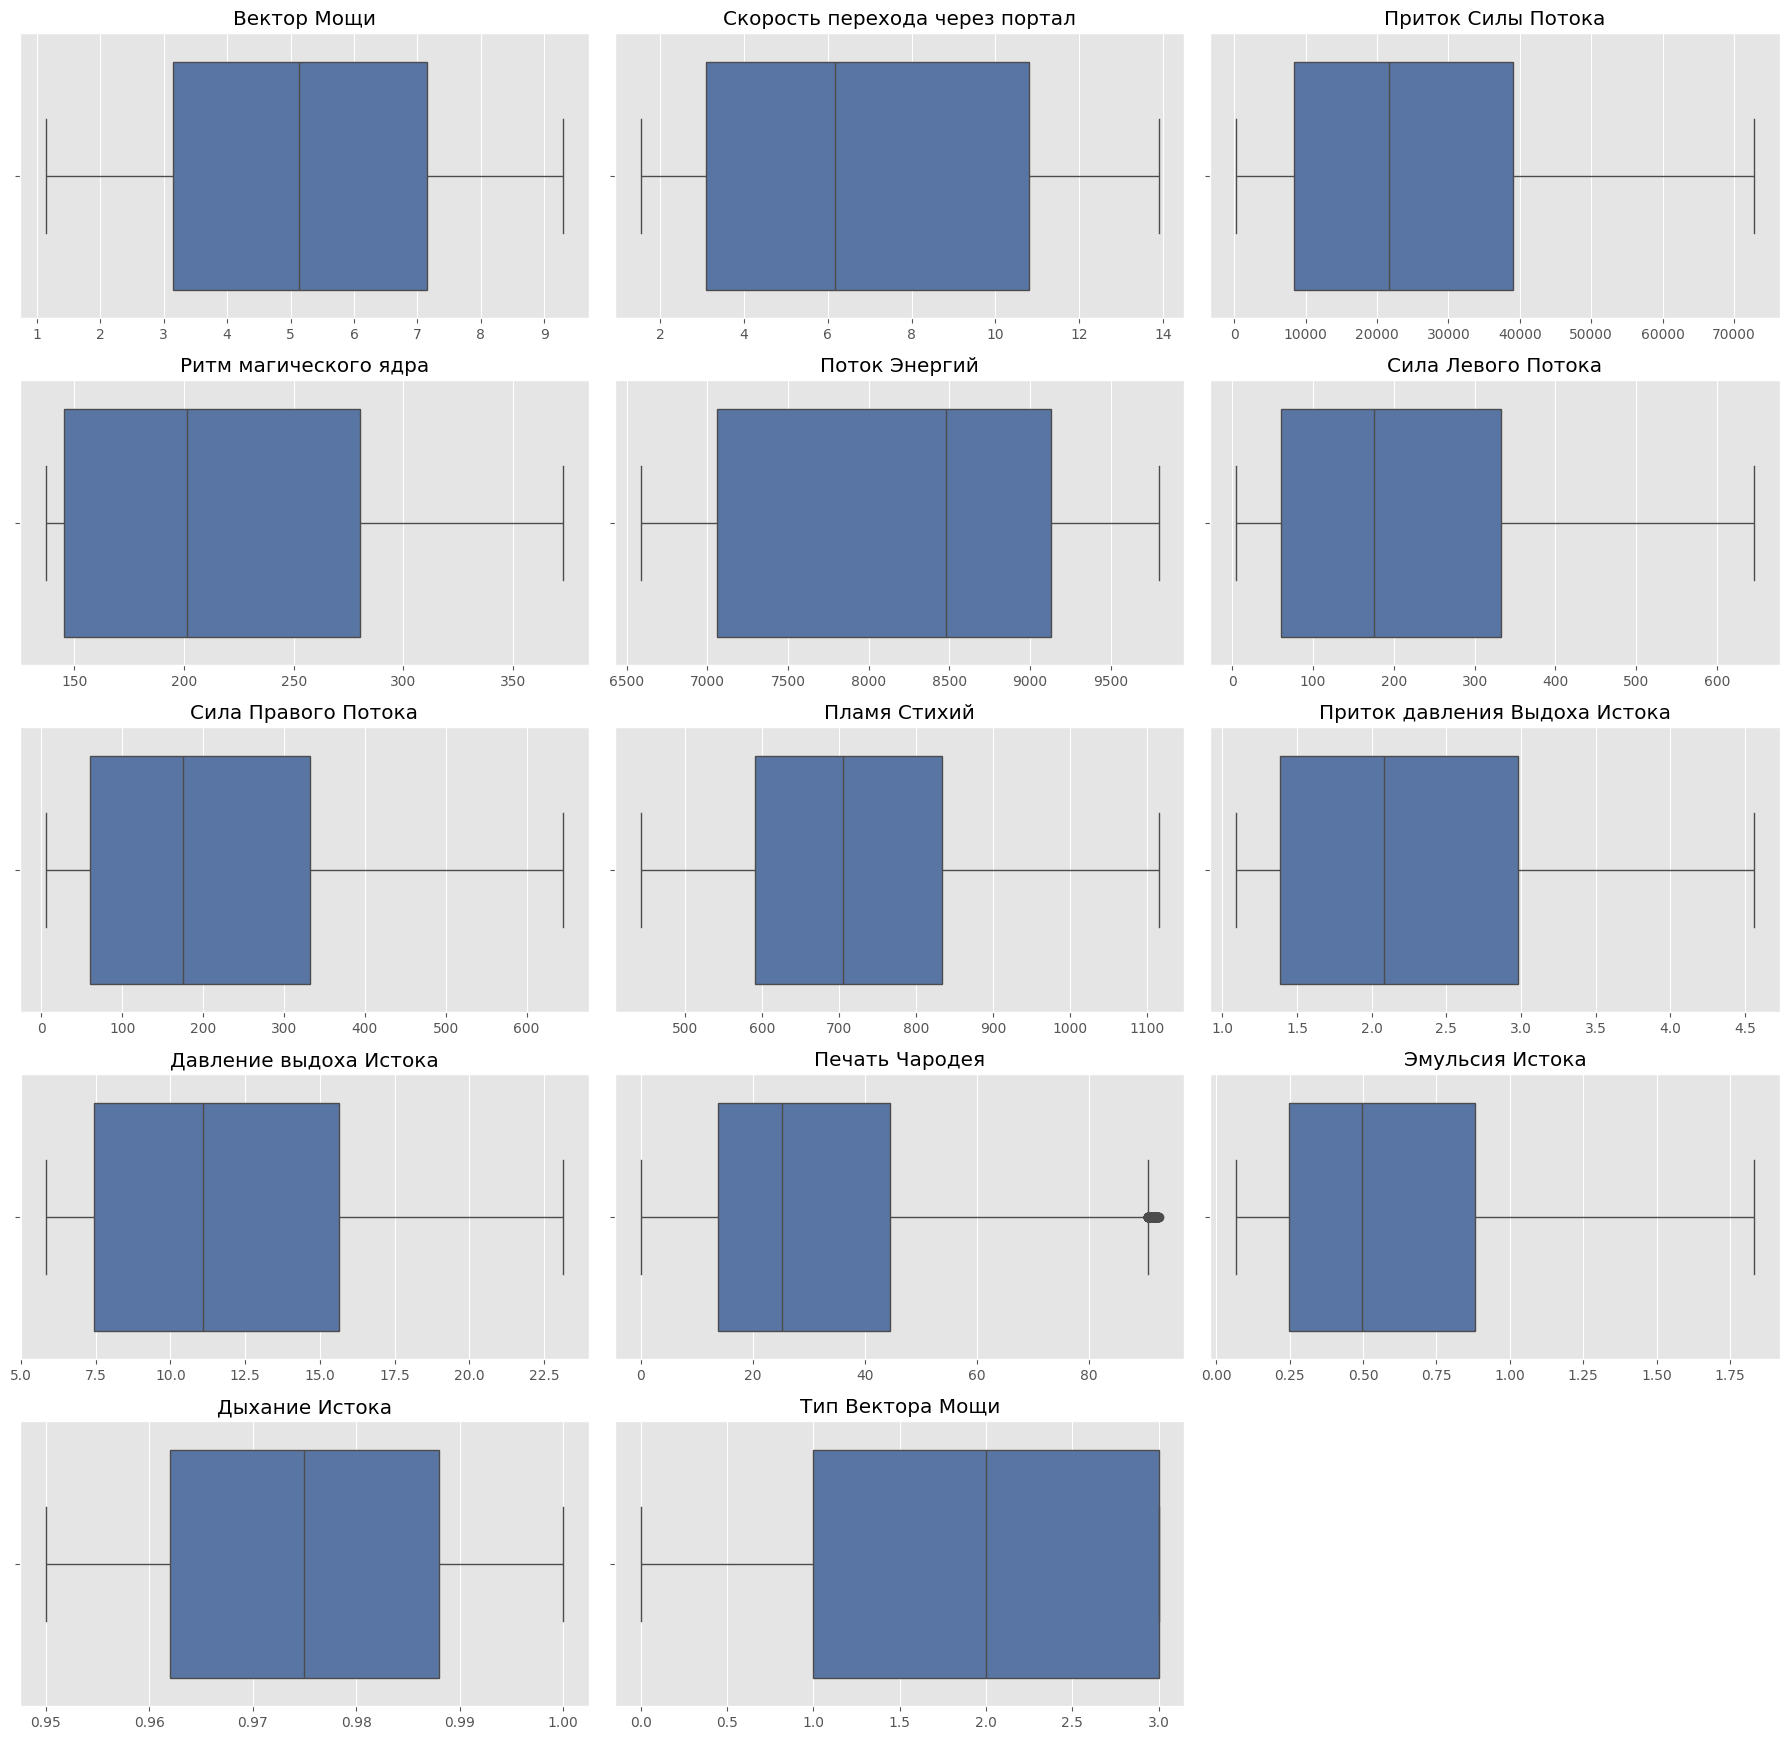

In [11]:
num_cols_box = X_train_stat.select_dtypes(include=[np.number]).columns.tolist()

n = len(num_cols_box)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 3.5 * nrows))
axes = np.array(axes).reshape(-1)

for i, col in enumerate(num_cols_box):
    ax = axes[i]
    sns.boxplot(x=X_train_stat[col], ax=ax, color="#4C72B0")
    ax.set_title(col)
    ax.set_xlabel("")

for j in range(n, len(axes)):
    axes[j].axis("off")

plt.tight_layout()


По диаграммам «ящик с усами» видно, что распределения признаков сильно отличаются по масштабу и форме.

- Для части признаков наблюдается выраженная асимметрия и «длинные усы» вправо (например, потоки/мощности и давления) — это признак наличия редких, но очень больших значений. Такие наблюдения потенциально являются выбросами и могут смещать обучение моделей (особенно чувствительных к масштабу и экстремальным значениям).
- У некоторых признаков разброс умеренный и основная масса значений лежит компактно (коробка относительно узкая), однако при этом встречаются точки далеко за пределами «усов» — например, у `Печать Чародея` заметен одиночный экстремум, который явно отличается от основной выборки.
- Есть признаки с очень малой вариативностью: `Дыхание Истока` почти постоянно около 1 (коробка узкая, усы короткие). Такие признаки слабо информативны и могут плохо влиять на методы, основанные на расстояниях, если не выполнить нормализацию.
- `Вектор Мощи` и `Тип Вектора Мощи` выглядят дискретными (ступенчатая структура), что объясняется ограниченным числом возможных значений.

В целом графики подтверждают, что в данных присутствуют выбросы (в том числе по нескольким признакам), поэтому дальше оправдано применение формальных методов поиска выбросов (IQR и Robust Z-score) и удаление только тех строк, которые подтверждаются обоими критериями (пересечение), чтобы снизить риск удалить «нормальные» наблюдения.

Число строк-выбросов по IQR: 199
Число строк-выбросов по Robust Z-score: 1062
Пересечение (финальные выбросы): 199


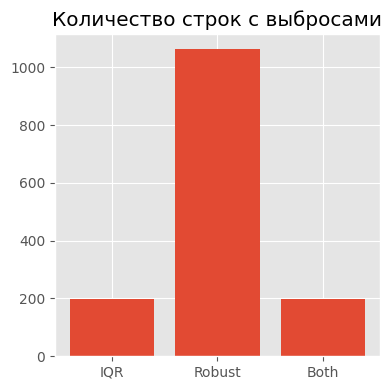

In [12]:
X_train_out = X_train_stat.copy()

num_cols = X_train_out.select_dtypes(include=[np.number]).columns.tolist()

outliers_iqr = set()
outliers_robust = set()

for col in num_cols:
    s = X_train_out[col]

    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:
        continue
    k = 1.5
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    mask_iqr = (s < lower) | (s > upper)
    outliers_iqr.update(s[mask_iqr].index.tolist())

    med = s.median()
    mad = (s - med).abs().median()
    if mad == 0:
        continue
    z = 0.6745 * (s - med) / mad
    thresh = 3
    mask_robust = z.abs() > thresh
    outliers_robust.update(s[mask_robust].index.tolist())

outliers_iqr = set(outliers_iqr)
outliers_robust = set(outliers_robust)

outliers_both = sorted(list(outliers_iqr & outliers_robust))

print("Число строк-выбросов по IQR:", len(outliers_iqr))
print("Число строк-выбросов по Robust Z-score:", len(outliers_robust))
print("Пересечение (финальные выбросы):", len(outliers_both))

plt.figure(figsize=(4, 4))
plt.bar(["IQR", "Robust", "Both"], [len(outliers_iqr), len(outliers_robust), len(outliers_both)])
plt.title("Количество строк с выбросами")
plt.tight_layout()

X_train_no_out = X_train_out.drop(index=outliers_both)
y_train_no_out = y_train.loc[X_train_no_out.index]

X_train_knn_no_out = X_train_knn.loc[X_train_no_out.index]

По методу IQR нашлось умеренное число выбросов (199 строк). Robust Z-score при выбранном пороге `thresh = 3` оказался более чувствительным и отметил больше “подозрительных” наблюдений (1062 строки). В финальный набор выбросов берём только строки, которые одновременно считаются выбросами и по IQR, и по Robust Z-score. В нашем случае пересечение получилось 199 строк — именно они и будут удалены из обучающей выборки как наиболее очевидные выбросы.

### Поиск аномалий (Isolation Forest, One-class SVM, DBSCAN)

Isolation Forest аномалии: 935
One-class SVM аномалии: 935
DBSCAN аномалии: 2132
Пересечение аномалий (финальный набор): 0


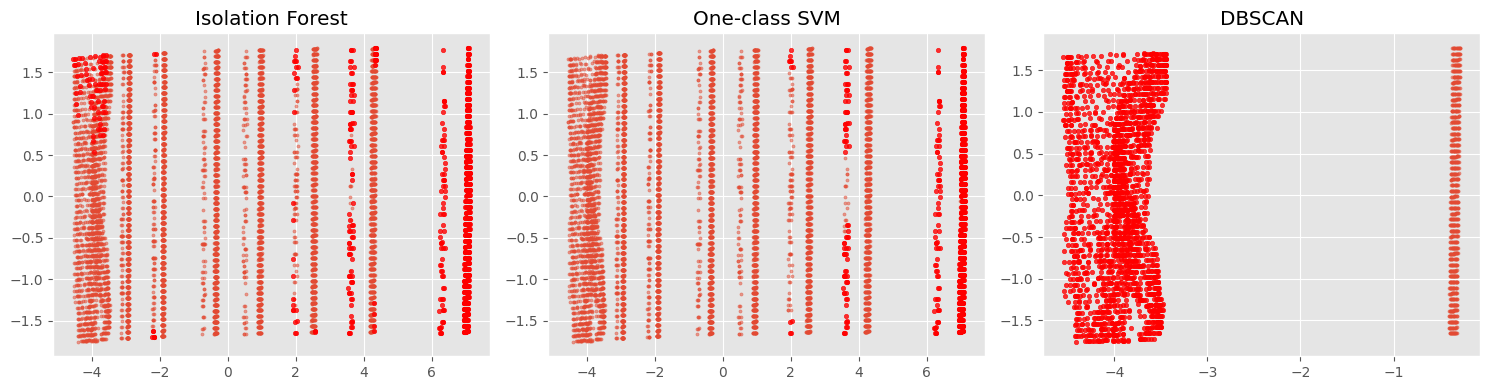

In [13]:
scaler_anom = StandardScaler()
X_anom_scaled = scaler_anom.fit_transform(X_train_no_out)

iforest = IForest(random_state=SEED)
iforest.fit(X_anom_scaled)
labels_if = iforest.labels_ 

ocsvm = OCSVM()
ocsvm.fit(X_anom_scaled)
labels_oc = ocsvm.labels_

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_anom_scaled)
labels_db = dbscan.labels_

idx_if = set(X_train_no_out.index[np.where(labels_if == 1)[0]].tolist())
idx_oc = set(X_train_no_out.index[np.where(labels_oc == 1)[0]].tolist())
idx_db = set(X_train_no_out.index[np.where(labels_db == 1)[0]].tolist())

print("Isolation Forest аномалии:", len(idx_if))
print("One-class SVM аномалии:", len(idx_oc))
print("DBSCAN аномалии:", len(idx_db))

pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_anom_scaled)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
methods = [(labels_if, "Isolation Forest"), (labels_oc, "One-class SVM"), (labels_db, "DBSCAN")]

for ax, (labels, title) in zip(axes, methods):
    normal_mask = labels == 0
    anom_mask = labels == 1
    ax.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1], s=5, alpha=0.5, label="норма")
    ax.scatter(X_pca[anom_mask, 0], X_pca[anom_mask, 1], s=10, alpha=0.8, label="аномалии", color="red")
    ax.set_title(title)

plt.tight_layout()

anom_all = sorted(list(idx_if & idx_oc & idx_db))
print("Пересечение аномалий (финальный набор):", len(anom_all))

X_train_clean = X_train_no_out.drop(index=anom_all)
y_train_clean = y_train_no_out.loc[X_train_clean.index]

X_train_clean_knn = X_train_knn_no_out.loc[X_train_clean.index]

X_test_clean = X_test_stat.copy()
X_test_clean_knn = X_test_knn.copy()

Isolation Forest и One-class SVM дают очень похожую картину — они отмечают примерно одни и те же “подозрительные” точки. DBSCAN работает по плотности, поэтому он выделяет аномалии по‑другому: видно, что он “цепляется” за отдельные области/группы точек, а не повторяет первые два метода. В итоге модели между собой не сходятся и финальный набор аномалий получается нулевым

<a id="sec-1-6"></a>
## 1.6. Подведение итогов раздела 1

[к оглавлению](#toc)

Итог:

- загрузка данных и приведение типов;
- удаление служебных/неинформативных признаков;
- разбиение train/test;
- заполнение пропусков (статистика и `KNNImputer`), кодирование `Тип Вектора Мощи`;
- очистка обучающей выборки от выбросов и аномалий.

Дальнейшая работа ведётся на `X_train_clean`, `y_train_clean` (и варианте с KNN-заполнением). Тестовая выборка — `X_test_clean`.

<a id="sec-2"></a>
# 2. Генерация новых признаков

[к оглавлению](#toc)

<a id="sec-2-1"></a>
## 2.1. Корреляционный анализ входных признаков (построение тепловых карт корреляции)

[к оглавлению](#toc)

Корреляционный анализ числовых признаков и выявление сильных зависимостей.

Топ 10 пар по модулю корреляции:
Сила Левого Потока — Сила Правого Потока: 1.000
Приток давления Выдоха Истока — Давление выдоха Истока: 0.999
Приток Силы Потока — Сила Левого Потока: 0.999
Приток Силы Потока — Сила Правого Потока: 0.999
Приток Силы Потока — Приток давления Выдоха Истока: 0.999
Сила Левого Потока — Приток давления Выдоха Истока: 0.998
Сила Правого Потока — Приток давления Выдоха Истока: 0.998
Приток Силы Потока — Давление выдоха Истока: 0.998
Сила Левого Потока — Давление выдоха Истока: 0.996
Сила Правого Потока — Давление выдоха Истока: 0.996


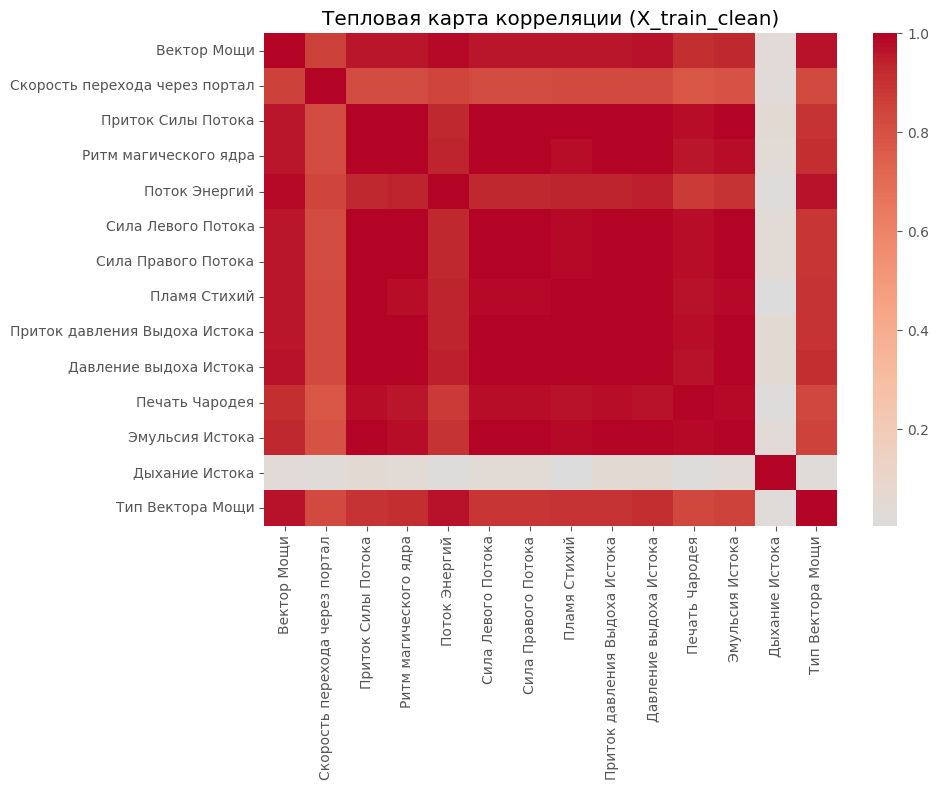

In [14]:
corr = X_train_clean.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Тепловая карта корреляции (X_train_clean)")
plt.tight_layout()

pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        val = corr.iloc[i, j]
        pairs.append((cols[i], cols[j], val))

pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
print("Топ 10 пар по модулю корреляции:")
for a, b, v in pairs_sorted[:10]:
    print(f"{a} — {b}: {v:.3f}")

Тепловая карта показывает, что многие признаки очень сильно коррелируют между собой (есть прям почти “одинаковые” по смыслу/формуле). Это плохой сигнал для линейных моделей: появляется мультиколлинеарность и модель может быть нестабильной. Поэтому дальше логично делать feature engineering (агрегаты) и/или убирать часть дублей.

<a id="sec-2-2"></a>
## 2.2. Исправление проблемы мультиколлинеарности в данных

[к оглавлению](#toc)

Снижение мультиколлинеарности: генерация агрегированных признаков по формулам предметной области и исключение части исходных признаков с высокой корреляцией.

In [15]:
X_train_fe = X_train_clean.copy()
X_test_fe = X_test_clean.copy()

if set(["Сила Левого Потока", "Сила Правого Потока", "Приток Силы Потока"]).issubset(X_train_fe.columns):
    X_train_fe["Суммарная мощность потоков"] = (
        X_train_fe["Сила Левого Потока"]
        + X_train_fe["Сила Правого Потока"]
        + X_train_fe["Приток Силы Потока"]
    )
    X_test_fe["Суммарная мощность потоков"] = (
        X_test_fe["Сила Левого Потока"]
        + X_test_fe["Сила Правого Потока"]
        + X_test_fe["Приток Силы Потока"]
    )

if set(["Ритм магического ядра", "Приток Силы Потока"]).issubset(X_train_fe.columns):
    X_train_fe["Сила ядра"] = (
        X_train_fe["Ритм магического ядра"] * X_train_fe["Приток Силы Потока"]
    )
    X_test_fe["Сила ядра"] = (
        X_test_fe["Ритм магического ядра"] * X_test_fe["Приток Силы Потока"]
    )

if set(["Приток давления Выдоха Истока", "Давление выдоха Истока"]).issubset(X_train_fe.columns):
    X_train_fe["Общее выходное давление"] = (
        X_train_fe["Приток давления Выдоха Истока"]
        + X_train_fe["Давление выдоха Истока"]
    )
    X_test_fe["Общее выходное давление"] = (
        X_test_fe["Приток давления Выдоха Истока"]
        + X_test_fe["Давление выдоха Истока"]
    )

cols_to_drop_fe = []
if "Сила Правого Потока" in X_train_fe.columns:
    cols_to_drop_fe.append("Сила Правого Потока")
if "Приток давления Выдоха Истока" in X_train_fe.columns:
    cols_to_drop_fe.append("Приток давления Выдоха Истока")

X_train_fe = X_train_fe.drop(columns=cols_to_drop_fe)
X_test_fe = X_test_fe.drop(columns=cols_to_drop_fe)

print("Удалённые признаки:", cols_to_drop_fe)
print("Размер X_train_fe:", X_train_fe.shape)

X_train_fe_knn = X_train_clean_knn.copy()
X_test_fe_knn = X_test_clean_knn.copy()

if set(["Сила Левого Потока", "Сила Правого Потока", "Приток Силы Потока"]).issubset(X_train_fe_knn.columns):
    X_train_fe_knn["Суммарная мощность потоков"] = (
        X_train_fe_knn["Сила Левого Потока"]
        + X_train_fe_knn["Сила Правого Потока"]
        + X_train_fe_knn["Приток Силы Потока"]
    )
    X_test_fe_knn["Суммарная мощность потоков"] = (
        X_test_fe_knn["Сила Левого Потока"]
        + X_test_fe_knn["Сила Правого Потока"]
        + X_test_fe_knn["Приток Силы Потока"]
    )

if set(["Ритм магического ядра", "Приток Силы Потока"]).issubset(X_train_fe_knn.columns):
    X_train_fe_knn["Сила ядра"] = (
        X_train_fe_knn["Ритм магического ядра"] * X_train_fe_knn["Приток Силы Потока"]
    )
    X_test_fe_knn["Сила ядра"] = (
        X_test_fe_knn["Ритм магического ядра"] * X_test_fe_knn["Приток Силы Потока"]
    )

if set(["Приток давления Выдоха Истока", "Давление выдоха Истока"]).issubset(X_train_fe_knn.columns):
    X_train_fe_knn["Общее выходное давление"] = (
        X_train_fe_knn["Приток давления Выдоха Истока"]
        + X_train_fe_knn["Давление выдоха Истока"]
    )
    X_test_fe_knn["Общее выходное давление"] = (
        X_test_fe_knn["Приток давления Выдоха Истока"]
        + X_test_fe_knn["Давление выдоха Истока"]
    )

X_train_fe_knn = X_train_fe_knn.drop(columns=cols_to_drop_fe)
X_test_fe_knn = X_test_fe_knn.drop(columns=cols_to_drop_fe)

print("Размер X_train_fe_knn:", X_train_fe_knn.shape)

Удалённые признаки: ['Сила Правого Потока', 'Приток давления Выдоха Истока']
Размер X_train_fe: (9348, 15)
Размер X_train_fe_knn: (9348, 15)


<a id="sec-2-3"></a>
## 2.3. Скалирование данных

[к оглавлению](#toc)

Здесь анализирую масштабы признаков и, при необходимости, применяю скалирование. Сохраняю несколько версий датасета:

- без скалирования;
- со `StandardScaler`;
- со `MinMaxScaler`;

In [16]:
print("Описание X_train_fe:")
print(X_train_fe.describe().T[["mean", "std", "min", "max"]])

scaler_std = StandardScaler()
X_train_fe_std_arr = scaler_std.fit_transform(X_train_fe)
X_test_fe_std_arr = scaler_std.transform(X_test_fe)

X_train_fe_std = pd.DataFrame(X_train_fe_std_arr, columns=X_train_fe.columns, index=X_train_fe.index)
X_test_fe_std = pd.DataFrame(X_test_fe_std_arr, columns=X_test_fe.columns, index=X_test_fe.index)

scaler_mm = MinMaxScaler()
X_train_fe_mm_arr = scaler_mm.fit_transform(X_train_fe)
X_test_fe_mm_arr = scaler_mm.transform(X_test_fe)

X_train_fe_mm = pd.DataFrame(X_train_fe_mm_arr, columns=X_train_fe.columns, index=X_train_fe.index)
X_test_fe_mm = pd.DataFrame(X_test_fe_mm_arr, columns=X_test_fe.columns, index=X_test_fe.index)

print("Размеры вариантов данных:")
print("X_train_fe:", X_train_fe.shape)
print("X_train_fe_std:", X_train_fe_std.shape)
print("X_train_fe_mm:", X_train_fe_mm.shape)

Описание X_train_fe:
                                        mean           std           min  \
Вектор Мощи                     5.067852e+00  2.585897e+00      1.138000   
Скорость перехода через портал  6.962275e+00  4.156561e+00      1.543320   
Приток Силы Потока              2.621470e+04  2.136967e+04    268.738000   
Ритм магического ядра           2.202244e+02  7.897920e+01    136.939406   
Поток Энергий                   8.162388e+03  1.078871e+03   6589.002000   
Сила Левого Потока              2.178408e+02  1.932294e+02      5.304000   
Пламя Стихий                    7.272692e+02  1.671279e+02    442.364000   
Давление выдоха Истока          1.205885e+01  5.175551e+00      5.828000   
Печать Чародея                  3.235882e+01  2.471191e+01      0.000000   
Эмульсия Истока                 6.368794e-01  4.844181e-01      0.068000   
Дыхание Истока                  9.754782e-01  1.464240e-02      0.950000   
Тип Вектора Мощи                1.632970e+00  1.150851e+00      0.0

### Дополнительное задание: PCA

PCA на данных после ЛР4 (до генерации признаков): оценка числа компонент для сохранения ≥95% дисперсии и построение преобразованных train/test.

Оптимальное число компонент по критерию 95% дисперсии: 3
Форма X_train_pca: (9348, 3)
Форма X_test_pca: (2387, 3)


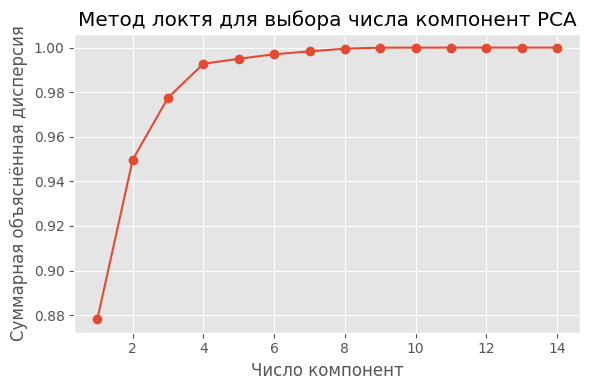

In [17]:
scaler_pca = StandardScaler()
X_train_pca_base = scaler_pca.fit_transform(X_train_clean)
X_test_pca_base = scaler_pca.transform(X_test_clean)

max_components = min(15, X_train_pca_base.shape[1])
explained = []

for n in range(1, max_components + 1):
    pca_tmp = PCA(n_components=n, random_state=SEED)
    pca_tmp.fit(X_train_pca_base)
    explained.append(pca_tmp.explained_variance_ratio_.sum())

plt.figure(figsize=(6, 4))
plt.plot(range(1, max_components + 1), explained, marker="o")
plt.xlabel("Число компонент")
plt.ylabel("Суммарная объяснённая дисперсия")
plt.title("Метод локтя для выбора числа компонент PCA")
plt.grid(True)
plt.tight_layout()

n_opt = 1
for i, val in enumerate(explained, start=1):
    if val >= 0.95:
        n_opt = i
        break

print("Оптимальное число компонент по критерию 95% дисперсии:", n_opt)

pca_final = PCA(n_components=n_opt, random_state=SEED)
X_train_pca_arr = pca_final.fit_transform(X_train_pca_base)
X_test_pca_arr = pca_final.transform(X_test_pca_base)

X_train_pca = pd.DataFrame(X_train_pca_arr, index=X_train_clean.index)
X_test_pca = pd.DataFrame(X_test_pca_arr, index=X_test_clean.index)

print("Форма X_train_pca:", X_train_pca.shape)
print("Форма X_test_pca:", X_test_pca.shape)

График показывает накопленную объяснённую дисперсию от количества компонент PCA. В начале рост резкий, а дальше кривая быстро “выпрямляется” — дополнительные компоненты дают уже мало пользы. По сути “локоть” говорит, что нескольких компонент достаточно, чтобы сохранить почти всю информацию

<a id="sec-2-4"></a>
## 2.4. Подведение итогов раздела 2

[к оглавлению](#toc)

Итог:

- выполнен корреляционный анализ;
- снижена мультиколлинеарность за счёт новых агрегированных признаков;
- подготовлены варианты данных без скалирования, со `StandardScaler` и `MinMaxScaler` (и PCA при необходимости).

<a id="sec-3"></a>
# 3. Выбор моделей ML и метрик

[к оглавлению](#toc)

<a id="sec-3-1"></a>
## 3.1. Визуальный анализ связи признаков с целевым признаком

[к оглавлению](#toc)

Проверка связи отдельных признаков с таргетом и оценка корреляций с целевой переменной.

Топ 10 признаков по модулю корреляции с таргетом:
Сила ядра: 0.044
Суммарная мощность потоков: 0.041
Приток Силы Потока: 0.041
Сила Левого Потока: 0.041
Поток Энергий: 0.041
Ритм магического ядра: 0.037
Вектор Мощи: 0.033
Тип Вектора Мощи: 0.027
Эмульсия Истока: 0.026
Скорость перехода через портал: 0.024


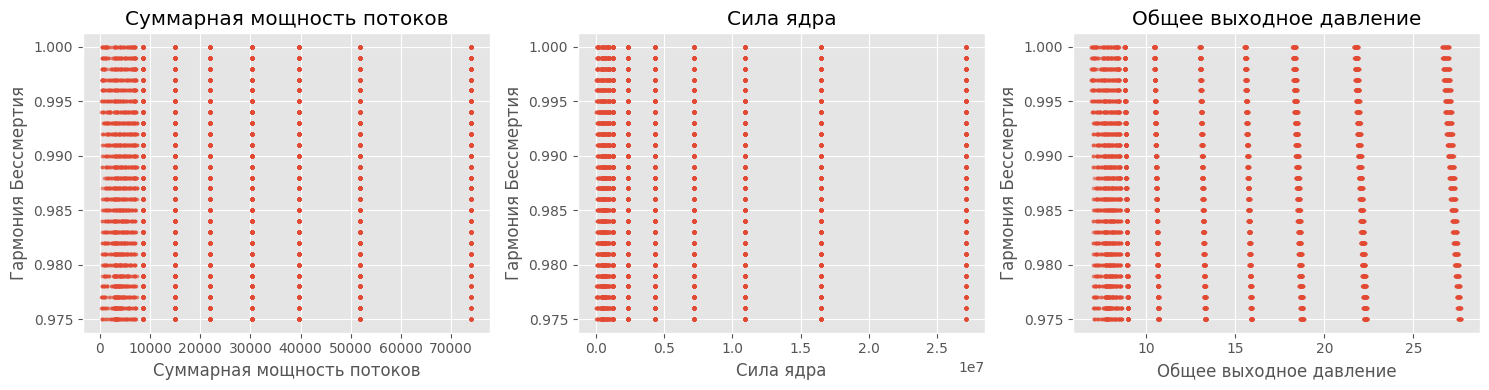

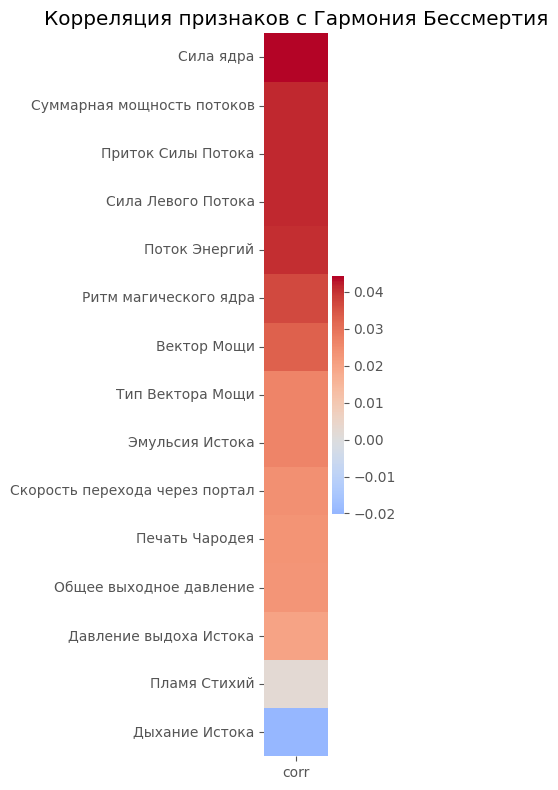

In [18]:
features_for_scatter = [
    "Суммарная мощность потоков",
    "Сила ядра",
    "Общее выходное давление",
]

plt.figure(figsize=(15, 4))
for i, col in enumerate(features_for_scatter, start=1):
    if col not in X_train_fe.columns:
        continue
    plt.subplot(1, len(features_for_scatter), i)
    plt.scatter(X_train_fe[col], y_train_clean, s=5, alpha=0.5)
    plt.xlabel(col)
    plt.ylabel(TARGET_COL)
    plt.title(col)
plt.tight_layout()

corr_target = (
    pd.concat([X_train_fe, y_train_clean], axis=1)
    .corr()[TARGET_COL]
    .drop(TARGET_COL)
    .sort_values(ascending=False)
)

plt.figure(figsize=(4, max(4, 0.4 * len(corr_target) + 2)))
sns.heatmap(corr_target.to_frame(name="corr"), cmap="coolwarm", center=0)
plt.title("Корреляция признаков с Гармония Бессмертия")
plt.tight_layout()

print("Топ 10 признаков по модулю корреляции с таргетом:")
for name, val in corr_target.reindex(corr_target.abs().sort_values(ascending=False).index)[:10].items():
    print(f"{name}: {val:.3f}")

На точечных графиках заметно, что целевой признак принимает ограниченное число значений, поэтому точки образуют “горизонтальные полосы”. Из‑за этого визуально не проявляется гладкая линейная зависимость таргета от отдельных признаков: тренд если и есть, то слабый и «ступенчатый».

Хитмапа корреляции с таргетом это подтверждает: абсолютные значения корреляций небольшие (порядка нескольких сотых, до ~0.04), то есть простая линейная связь выражена слабо. Поэтому имеет смысл рассматривать модели, которые умеют ловить нелинейности и взаимодействия признаков (деревья/бустинг), а линейные модели использовать скорее как базовый ориентир.

Набор моделей для регрессии:

- `LinearRegression`
- `Ridge`
- `RandomForestRegressor`
- `GradientBoostingRegressor`

Метрики качества:

- MAE
- RMSE
- R²

Целевая метрика для подбора гиперпараметров — RMSE.

In [19]:
MODEL_CLASSES = {
    "linreg": LinearRegression,
    "ridge": Ridge,
    "rf": RandomForestRegressor,
    "gbr": GradientBoostingRegressor,
}

MODEL_NAMES = {
    "linreg": "LinearRegression",
    "ridge": "Ridge",
    "rf": "RandomForestRegressor",
    "gbr": "GradientBoostingRegressor",
}

list(MODEL_NAMES.items())

[('linreg', 'LinearRegression'),
 ('ridge', 'Ridge'),
 ('rf', 'RandomForestRegressor'),
 ('gbr', 'GradientBoostingRegressor')]

In [20]:
def suggest_params(trial, model_key: str):
    if model_key == "linreg":
        return {}

    if model_key == "ridge":
        return {
            "alpha": trial.suggest_loguniform("alpha", 1e-3, 10.0),
        }

    if model_key == "rf":
        return {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        }

    if model_key == "gbr":
        return {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
        }

    return {}

In [21]:
def compute_regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    }


METRIC_NAMES = ["MAE", "RMSE", "R2"]
METRIC_TARGET = "RMSE"

<a id="sec-4"></a>
# 4. Обучение моделей ML и подбор гиперпараметров

[к оглавлению](#toc)

Подбор гиперпараметров на наборах `X_train_fe`, `X_train_fe_std`, `X_train_fe_mm` с помощью `optuna` и кросс-валидации. Целевая метрика — RMSE.

In [22]:
DATASETS = {
    "fe": {
        "X_train": X_train_fe,
        "X_test": X_test_fe,
        "description": "после генерации признаков, без скалирования",
    },
    "fe_std": {
        "X_train": X_train_fe_std,
        "X_test": X_test_fe_std,
        "description": "после генерации признаков, StandardScaler",
    },
    "fe_mm": {
        "X_train": X_train_fe_mm,
        "X_test": X_test_fe_mm,
        "description": "после генерации признаков, MinMaxScaler",
    },
}

N_TRIALS = {
    "linreg": 1,
    "ridge": 20,
    "rf": 25,
    "gbr": 25,
}

BEST_PARAMS = {}
BEST_SCORES = {}


def objective_factory(model_key: str, X, y):
    def objective(trial):
        params = suggest_params(trial, model_key)

        if model_key in {"rf", "gbr"}:
            params = {**params, "random_state": SEED}

        ModelClass = MODEL_CLASSES[model_key]
        kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
        rmses = []

        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = ModelClass(**params)
            model.fit(X_tr, y_tr)
            y_val_pred = model.predict(X_val)
            rmse = mean_squared_error(y_val, y_val_pred, squared=False)
            rmses.append(rmse)

        return float(np.mean(rmses))

    return objective


for data_key, data in DATASETS.items():
    X_tr = data["X_train"]
    y_tr = y_train_clean
    print("\n=== Датасет:", data_key, "===")

    for model_key in MODEL_CLASSES.keys():
        n_trials = N_TRIALS.get(model_key, 20)
        print(f"Модель: {MODEL_NAMES[model_key]}, trials={n_trials}")

        study = optuna.create_study(direction="minimize")
        study.optimize(objective_factory(model_key, X_tr, y_tr), n_trials=n_trials, show_progress_bar=False)

        BEST_PARAMS[(model_key, data_key)] = study.best_params
        BEST_SCORES[(model_key, data_key)] = study.best_value

        print("Лучший RMSE (CV):", round(study.best_value, 4))
        print("Лучшие параметры:", study.best_params)


=== Датасет: fe ===
Модель: LinearRegression, trials=1
Лучший RMSE (CV): 0.0016
Лучшие параметры: {}
Модель: Ridge, trials=20
Лучший RMSE (CV): 0.0016
Лучшие параметры: {'alpha': 0.0010192082261586658}
Модель: RandomForestRegressor, trials=25
Лучший RMSE (CV): 0.0016
Лучшие параметры: {'n_estimators': 95, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4}
Модель: GradientBoostingRegressor, trials=25
Лучший RMSE (CV): 0.0007
Лучшие параметры: {'n_estimators': 189, 'learning_rate': 0.1308535565739599, 'max_depth': 6}

=== Датасет: fe_std ===
Модель: LinearRegression, trials=1
Лучший RMSE (CV): 0.0016
Лучшие параметры: {}
Модель: Ridge, trials=20
Лучший RMSE (CV): 0.0017
Лучшие параметры: {'alpha': 0.0010352095539362836}
Модель: RandomForestRegressor, trials=25
Лучший RMSE (CV): 0.0015
Лучшие параметры: {'n_estimators': 79, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 2}
Модель: GradientBoostingRegressor, trials=25
Лучший RMSE (CV): 0.0007
Лучшие параметры: {

<a id="sec-5"></a>
# 5. Вычисление метрик на новых данных

[к оглавлению](#toc)

Обучение моделей с найденными гиперпараметрами на train и расчёт метрик на train/test. Сравнение результатов в сводной таблице.

In [23]:
results = []

for data_key, data in DATASETS.items():
    X_tr = data["X_train"]
    X_te = data["X_test"]

    for model_key, ModelClass in MODEL_CLASSES.items():
        params = BEST_PARAMS.get((model_key, data_key), {}).copy()

        if model_key in {"rf", "gbr"}:
            params["random_state"] = SEED

        model = ModelClass(**params)
        model.fit(X_tr, y_train_clean)

        y_pred_tr = model.predict(X_tr)
        y_pred_te = model.predict(X_te)

        m_tr = compute_regression_metrics(y_train_clean, y_pred_tr)
        m_te = compute_regression_metrics(y_test, y_pred_te)

        results.append(
            {
                "dataset": data_key,
                "dataset_desc": data["description"],
                "model_key": model_key,
                "model": MODEL_NAMES[model_key],
                "RMSE_cv": BEST_SCORES.get((model_key, data_key)),
                "MAE_train": m_tr["MAE"],
                "RMSE_train": m_tr["RMSE"],
                "R2_train": m_tr["R2"],
                "MAE_test": m_te["MAE"],
                "RMSE_test": m_te["RMSE"],
                "R2_test": m_te["R2"],
            }
        )

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(["RMSE_test"]).reset_index(drop=True)
results_df_sorted

,dataset,dataset_desc,model_key,model,RMSE_cv,MAE_train,RMSE_train,R2_train,MAE_test,RMSE_test,R2_test
0,fe_std,"после генерации признаков, StandardScaler",gbr,GradientBoostingRegressor,0.000718,0.000160,0.000210,0.999214,0.000401,0.000671,0.991933
1,fe,"после генерации признаков, без скалирования",gbr,GradientBoostingRegressor,0.000744,0.000205,0.000274,0.998661,0.000438,0.000714,0.990870
2,fe_mm,"после генерации признаков, MinMaxScaler",gbr,GradientBoostingRegressor,0.000742,0.000230,0.000298,0.998414,0.000465,0.000741,0.990155
3,fe_mm,"после генерации признаков, MinMaxScaler",rf,RandomForestRegressor,0.001517,0.000525,0.001219,0.973575,0.000685,0.001393,0.965232
4,fe,"после генерации признаков, без скалирования",rf,RandomForestRegressor,0.001555,0.000576,0.001262,0.971675,0.000733,0.001442,0.962741
5,fe_std,"после генерации признаков, StandardScaler",rf,RandomForestRegressor,0.001545,0.000575,0.001287,0.970543,0.000728,0.001448,0.962396
6,fe,"после генерации признаков, без скалирования",ridge,Ridge,0.001592,0.001150,0.001588,0.955121,0.001128,0.001543,0.957306
7,fe_mm,"после генерации признаков, MinMaxScaler",linreg,LinearRegression,0.001591,0.001154,0.001587,0.955162,0.001132,0.001543,0.957298
8,fe,"после генерации признаков, без скалирования",linreg,LinearRegression,0.001591,0.001154,0.001587,0.955162,0.001132,0.001543,0.957298
9,fe_std,"после генерации признаков, StandardScaler",linreg,LinearRegression,0.001591,0.001154,0.001587,0.955162,0.001132,0.001543,0.957298


Вывод по текущим прогонам

- лучшая модель по качеству на тесте — **GradientBoostingRegressor** на датасете `fe_std` (после генерации признаков + `StandardScaler`):
  - `RMSE_test = 0.000671` (минимум среди всех вариантов)
  - `MAE_test = 0.000401`
  - `R2_test = 0.991933`
- ближайшие альтернативы — тоже **GradientBoostingRegressor**, но чуть хуже:
  - `fe`: `RMSE_test = 0.000714`, `MAE_test = 0.000438`, `R2_test = 0.990870`
  - `fe_mm`: `RMSE_test = 0.000741`, `MAE_test = 0.000465`, `R2_test = 0.990155`
- по сравнению с линейными моделями и случайным лесом бустинг заметно выигрывает:
  - `LinearRegression/Ridge` держатся около `RMSE_test ≈ 0.00154–0.00196`
  - `RandomForestRegressor` около `RMSE_test ≈ 0.00139–0.00145`
- сильного переобучения по метрикам не видно: на train метрики лучше, но разрыв умеренный (например, для лидера `RMSE_train = 0.000210` против `RMSE_test = 0.000671`), модель ведёт себя стабильно на тестовой выборке.

<a id="sec-6"></a>
# 6. Результат работы

[к оглавлению](#toc)


В рамках проекта была решена задача регрессии: прогноз целевого показателя **«Гармония Бессмертия»** по параметрам портала. На этапе изучения данных сформировано описание признаков и выделены служебные/неинформативные поля, после чего данные были корректно разделены на `train/test`.

Далее выполнена подготовка данных для обучения моделей:
- категориальный признак `Тип Вектора Мощи` закодирован с учётом естественного порядка категорий;
- пропуски обработаны двумя способами: статистическим (выбор значения по минимальной KL-дивергенции) и машинным (`KNNImputer`), качество машинного заполнения дополнительно проверено по `NRMSE`;
- на обучающей выборке выполнен поиск выбросов (IQR + robust z-score) и очистка данных от подтверждённых выбросов.

Для снижения мультиколлинеарности и улучшения описания предметной области были сгенерированы новые агрегированные признаки по формулам, а также подготовлены варианты данных без скалирования и со скалированием (`StandardScaler`, `MinMaxScaler`). Дополнительно рассмотрен PCA и подобрано число компонент по графику объяснённой дисперсии.

На финальном этапе был выбран пул моделей (линейные и ансамблевые), определены метрики (MAE/RMSE/R²), выполнен подбор гиперпараметров с помощью `optuna` и кросс-валидации. По итоговой таблице метрик на `train/test` лучшим вариантом стала модель **GradientBoostingRegressor** на датасете `fe_std` (генерация признаков + `StandardScaler`), показавшая минимальный `RMSE_test` и высокое значение `R2_test`. Разрыв между train/test умеренный, что указывает на стабильное качество без выраженного переобучения.